This notebook serves introduces a simplified end-to-end __machine learning__ modeling pipeline: (1) data prep, (2) modeling, (3) evaluation

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import torch
from chaosbench import dataset, config, utils, criterion

## Minimal Example
Let's build a pipeline with minimal example where we train only on one day...

In [3]:
# Define training/validation years (DO NOT use the year 2023, since its held-out for evaluation)
train_years = np.arange(2021, 2022)
val_years = test_years = np.arange(2022, 2023)

print(f'training years: {train_years}')
print(f'validation years: {val_years}')

training years: [2021]
validation years: [2022]


In [4]:
# Specify variables to be used for training
## More details on the variables can be found at https://leap-stc.github.io/ChaosBench/dataset.html
## We have atmos_vars, ocean_vars (optional), land_vars (optional)
TARGET_VARS = ['t-850', 'z-500', 'q-700'] # MANDATORY for evaluation

## Additional variables for feature engineering
atmos_vars = ['u-850', 'v-850'] ## Let's try adding wind speed 
land_vars = ['tp'] ## And some precipitation
ocean_vars = ['sosstsst'] ## And maybe some sea surface temperature

In [5]:
# Build the dataset (for training and validation, both on different years)
lead_time = 44

train_dataset = dataset.S2SObsDataset(
    years=train_years, # Years for training
    lead_time=lead_time, # Number of days ahead as target
    atmos_vars=TARGET_VARS + atmos_vars, # Atmospheric variables; if not given will use ALL 60 variables
    land_vars=land_vars, # Land variables
    ocean_vars=ocean_vars # Ocean variables
)

val_dataset = dataset.S2SObsDataset(
    years=val_years, # Years for validation
    lead_time=lead_time, # Number of days ahead as target
    atmos_vars=TARGET_VARS + atmos_vars, # Atmospheric variables; if not given will use ALL 60 variables
    land_vars=land_vars, # Land variables
    ocean_vars=ocean_vars # Ocean variables
)

/burg/home/jn2808/.conda/envs/bench/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [6]:
# Let's inspect the dataset
time_idx = 0 # Define the timestep to inspect e.g., first day of the year (1st January)
timestamp, val_x, val_y = val_dataset[time_idx]

print(f'input shape: (n_variables, latitude, longitude): {val_x.shape}')
print(f'input shape: (future_steps, n_variables, latitude, longitude): {val_y.shape}')

input shape: (n_variables, latitude, longitude): torch.Size([7, 121, 240])
input shape: (future_steps, n_variables, latitude, longitude): torch.Size([1, 7, 121, 240])


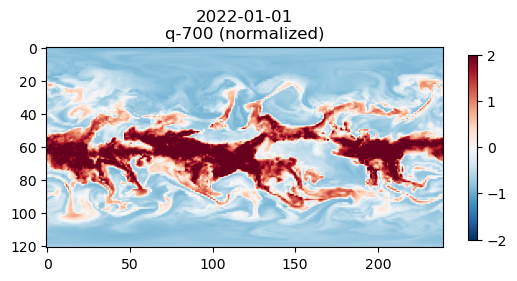

In [7]:
# Let's plot the dataset 
# e.g., humidity, q, at 700-hPa level --> which measures near surface wetness and can be useful to track drought!

time_idx = 0 # Define the timestep to inspect e.g., first day of the validation dataset 
param_name = 'q-700' # Define the variable to be inspected e.g., temperature t at pressure level 850 hPA

## Get the dataset
timestamp, val_x, val_y = val_dataset[time_idx]

## Get the index to subset
param_idx = val_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

## Plot!
plt.imshow(val_x[param_idx], cmap='RdBu_r', vmin=-2, vmax=2)

plt.colorbar(shrink=0.5)
plt.title(f'{utils.convert_time(timestamp)}\n{param_name} (normalized)')
plt.show();

In [8]:
# Now let's build a simple xgboost model trained on one date
import xgboost as xgb

## Defining our model (e.g., XGBoost)
## More info: https://xgboost.readthedocs.io/en/stable/get_started.html
model = xgb.XGBRegressor(tree_method="hist", device="cuda")

In [9]:
def transform_2d(x):
    """
    Helper function to transform the dataset into 2D array of shape (n_samples, n_features)
    """
    return x.view(
        -1, 
        len(train_dataset.atmos_vars) + len(train_dataset.land_vars) + len(train_dataset.ocean_vars)
    )

## Get our training data
time_idx = 0
_, train_x, train_y = train_dataset[time_idx]

## Fitting/training time!
model.fit(
    transform_2d(train_x),  # Input
    transform_2d(train_y)   # Target
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [10]:
# Infer on our validation set
time_idx = 0
_, val_x, val_y = val_dataset[time_idx]

## Infer
val_predict = model.predict(transform_2d(val_x))
val_predict = val_predict.reshape(val_y.shape)

In [11]:
# What does our prediction looks like
val_predict.shape, val_y.shape ## of shape (time, n_variables, latitude, longitude)

((1, 7, 121, 240), torch.Size([1, 7, 121, 240]))

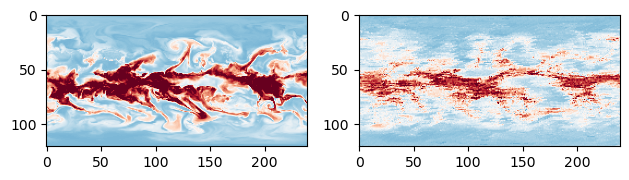

In [12]:
# Now let's put them side-by-side
## Say let's see the performance for q-700 prediction

param_name = 'q-700'
param_idx = val_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

f, ax = plt.subplots(1,2)
ax[0].imshow(val_y[0,param_idx], cmap='RdBu_r', vmin=-2, vmax=2) ## Truth
ax[1].imshow(val_predict[0,param_idx], cmap='RdBu_r', vmin=-2, vmax=2) ## prediction

plt.tight_layout()
plt.show();

In [13]:
# Now let's try computing its criterion (root mean-squared error)
rmse = criterion.RMSE(lat_adjusted=False) ## no latitude adjustment, i.e., normal RMSE

loss = rmse(
    torch.tensor(val_predict), 
    torch.tensor(val_y)
)

print(f'rmse loss: {loss}')

rmse loss: 0.7270668148994446


/local/ipykernel_407308/3434716229.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_y)


## Extended example
Now, lets train on multiple days at once...

In [14]:
# Checking how many days are there in our training years...
# Notice we have 45 days fewer, due to `n_step = 44` i.e., taking 44 days ahead as target
print(len(train_dataset))

320


In [15]:
# One easy way is to use DataLoader function provided by torch
# This can also be useful for subsequent demonstration for training more complicated models
from torch.utils.data import DataLoader

batch_size = 32 # This specifies the number of batches e.g., number of days to be loaded simultaneously
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [16]:
# For instance, lets check what a sample from a dataloader is by performing a single loop
for i, data in enumerate(train_dataloader):
    timestamp, train_x, train_y = data
    
    # Let's inspect the shape of the data (Notice: the added dimension at the front indicating batch_size==4)
    print(train_x.shape)
    print(train_y.shape)
    break

torch.Size([32, 7, 121, 240])
torch.Size([32, 1, 7, 121, 240])


In [17]:
# Now let's build our XGBoost again
model = xgb.XGBRegressor(tree_method="hist", device="cuda")

model.fit(
    transform_2d(train_x),  # Input
    transform_2d(train_y)   # Target
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [18]:
# Infer on our validation set
time_idx = 0
_, val_x, val_y = val_dataset[time_idx]

## Infer
val_predict = model.predict(transform_2d(val_x))
val_predict = val_predict.reshape(val_y.shape)

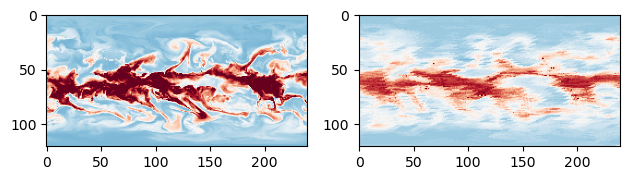

In [19]:
# Now let's put them side-by-side
## Say let's see the performance for q-700 prediction

param_name = 'q-700'
param_idx = val_dataset.era5_idx.index(
     utils.get_param_level_idx(*param_name.split('-')) # Get the variable index for plotting
)

f, ax = plt.subplots(1,2)
ax[0].imshow(val_y[0,param_idx], cmap='RdBu_r', vmin=-2, vmax=2) ## Truth
ax[1].imshow(val_predict[0,param_idx], cmap='RdBu_r', vmin=-2, vmax=2) ## prediction

plt.tight_layout()
plt.show();

In [20]:
# Now let's try computing its criterion (root mean-squared error)
rmse = criterion.RMSE(lat_adjusted=False) ## no latitude adjustment, i.e., normal RMSE

loss = rmse(
    torch.tensor(val_predict), 
    torch.tensor(val_y)
)

print(f'rmse loss: {loss}')

rmse loss: 0.6917271614074707


/local/ipykernel_407308/3434716229.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(val_y)


We see that the RMSE improves as we have more data points to train on!!
You can now go ahead and play around with using different variables, and years to train on.